## Final Phase 4 Project Submission

Please fill out:
* Student name: Mika Wambua Benson
* Student pace: part-time
* Scheduled project review date/time: 12/2/2025
* Instructor name: Samuel Karu
* Blog post URL: 

# Business Statement:
Hollywood movie studio aims to enhance the user engagement and its revenue by implementing an item-based-recommender system that suggest movies which are similar to the other users might have rated. Lets leverage the movie similarities based on the attributes like ratings and title as we seek to improve content and provide a highly personalized experience. The recommender systems built provides top 5 movie recommendations to a user, based on their ratings of other movies.


# Objectives
1. Retrieve the top 5 movie title recommended to user based on their ratings

2. Enable users explore a wide range of films similar to their preferences

3. Drive users subscriptions by suggesting appealing content


# Importing Necessary libraries

In [1]:
import pandas as pd
# importing relevant libraries, surprise library specifically used in building recommender system
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import SVD, KNNWithMeans, KNNBasic, KNNBaseline
# from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
# from surprise.model_selection import GridSearchCV
import numpy as np
from surprise import accuracy
from surprise import Dataset, Reader

import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


##  Dataset Understanding

### **Dataset Requirements**
For this project, we will use a movie dataset with the following columns:

1. `userId`: A unique ID representing each user.
2. `movieId`: A unique ID representing each movie.
3. `rating`: The numeric rating (e.g., 1-5 or 1-10) given by a user to a movie.
4. `title`: The name of the movie (used for querying recommendations).

# Data
We will use the **MovieLens dataset** (small version), which contains user ratings for movies along with metadata such as movie titles. You can download it from [MovieLens](https://grouplens.org/datasets/movielens/).

# Loading and Preparing the Dataset

### **Step 1: Load the Ratings Data**

In [2]:
# Load the ratings data
ratings_df = pd.read_csv('ratings.csv')

# Display the first few rows of the dataset
print(ratings_df.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [3]:
# dropping the timestamp column
ratings_df = ratings_df.drop(columns=['timestamp'], axis=1)
ratings_df.head() # check the 5 items on the dataset

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### **Step 2: Load the Movie data**


In [4]:
# Load the movies data
movies_df = pd.read_csv('movies.csv')

# Display the first few rows of the dataset
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### **Step 3: Merge Datasets**

Here lets merge the ratings_df with movies_df on movieId to include title for the movie in the ratings data

In [5]:
# Merge ratings with movie titles
movie_ratings_df = pd.merge(ratings_df, movies_df, on="movieId")

# Display the first few rows of the merged dataset
movie_ratings_df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [6]:
# Create function that gives a summary for Exploratory Data Analysis
def summarize_dataframe(movie_ratings_df):
    print(f"Here is the detailed information about the dataframe: {movie_ratings_df.info()}")
    print(f"Shape of the DataFrame: {movie_ratings_df.shape}")  # Number of rows and columns
    print("\nMissing Values per Column:")
    print(movie_ratings_df.isnull().sum())  # Count of missing values per column
    print(f"\nTotal Missing Values: {movie_ratings_df.isnull().sum().sum()}")  # Total missing values in the dataset
    print(f"\nNumber of Duplicate Rows: {movie_ratings_df.duplicated().sum()}")  # Count of duplicate rows

# Example usage:
summarize_dataframe(movie_ratings_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   title    100836 non-null  object 
 4   genres   100836 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 3.8+ MB
Here is the detailed information about the dataframe: None
Shape of the DataFrame: (100836, 5)

Missing Values per Column:
userId     0
movieId    0
rating     0
title      0
genres     0
dtype: int64

Total Missing Values: 0

Number of Duplicate Rows: 0


In [7]:
# check for unique values in the genres column
print('Unique genres')
print(movie_ratings_df['genres'].unique())

Unique genres
['Adventure|Animation|Children|Comedy|Fantasy' 'Comedy|Romance'
 'Action|Crime|Thriller' 'Mystery|Thriller' 'Crime|Mystery|Thriller'
 'Action|Comedy|Horror|Thriller' 'Adventure|Comedy|Crime|Romance'
 'Action|Drama|War' 'Action|Drama|Romance|War' 'Comedy|War'
 'Action|Romance|Western' 'Comedy' 'Adventure|Comedy' 'Comedy|Drama'
 'Action|Adventure|Sci-Fi' 'Comedy|Crime|Drama|Thriller'
 'Action|Crime|Drama|Thriller' 'Comedy|Drama|Romance|War'
 'Adventure|Children|Romance' 'Action|Comedy|Crime|Fantasy'
 'Action|Thriller' 'Thriller' 'Action|Adventure|Sci-Fi|Thriller'
 'Drama|War' 'Comedy|Romance|Thriller' 'Action|Adventure|Comedy|Romance'
 'Action|Drama|Western' 'Adventure|Drama|Western' 'Crime|Horror|Thriller'
 'Animation|Children|Fantasy|Musical' 'Action|Adventure|Mystery|Thriller'
 'Adventure|Animation|Children|Fantasy|Musical'
 'Adventure|Animation|Children|Comedy|Fantasy|Sci-Fi'
 'Action|Adventure|Thriller' 'Action|Adventure|Romance|Thriller'
 'Adventure|Children|Fantasy|M

## **4. Exploratory Data Analysis**

In [8]:
# Here we split the genre column 
genres_split = movie_ratings_df['genres'].str.split('|').str[0]

# concatenate the new columns with the movie_ratings_df
movie_ratings_df = pd.concat([movie_ratings_df, genres_split], axis = 1)

# lets drop the original column with the genres
movie_ratings_df = movie_ratings_df.drop(columns = ['genres'])
movie_ratings_df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [9]:
movie_ratings_df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [10]:
# lets save a cleaned dataset to new csv file 
movie_ratings_df.to_csv('cleaned_movie_ratings.csv', index = False)

# Loading the cleaned csv file

In [11]:
movie_analysis_df = pd.read_csv('cleaned_movie_ratings.csv')
movie_analysis_df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [12]:
# check the number of ratings based on their counts
movie_analysis_df['rating'].value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

In [13]:
# here we get the count for the rating for each movie title for clear interpretation of dataset
movie_analysis_df.groupby('title')['rating'].count().sort_values(ascending = False).head(10)

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: rating, dtype: int64

In [14]:
# calculating the average rating per movie title
avg_rating_title = movie_analysis_df.groupby('title')['rating'].mean()
ratings = pd.DataFrame(avg_rating_title)
print(ratings)

                                             rating
title                                              
'71 (2014)                                 4.000000
'Hellboy': The Seeds of Creation (2004)    4.000000
'Round Midnight (1986)                     3.500000
'Salem's Lot (2004)                        5.000000
'Til There Was You (1997)                  4.000000
...                                             ...
eXistenZ (1999)                            3.863636
xXx (2002)                                 2.770833
xXx: State of the Union (2005)             2.000000
¡Three Amigos! (1986)                      3.134615
À nous la liberté (Freedom for Us) (1931)  1.000000

[9719 rows x 1 columns]


The output shows the Average ratings for the various movie title

Salem's Lot (2004) had the highest rating of 5.000000 

À nous la liberté (1931) had the lowest rating of 1.000000 


In [15]:
ratings['num_ratings'] = pd.DataFrame(movie_analysis_df.groupby('title')['rating'].count())
print(ratings)

                                             rating  num_ratings
title                                                           
'71 (2014)                                 4.000000            1
'Hellboy': The Seeds of Creation (2004)    4.000000            1
'Round Midnight (1986)                     3.500000            2
'Salem's Lot (2004)                        5.000000            1
'Til There Was You (1997)                  4.000000            2
...                                             ...          ...
eXistenZ (1999)                            3.863636           22
xXx (2002)                                 2.770833           24
xXx: State of the Union (2005)             2.000000            5
¡Three Amigos! (1986)                      3.134615           26
À nous la liberté (Freedom for Us) (1931)  1.000000            1

[9719 rows x 2 columns]


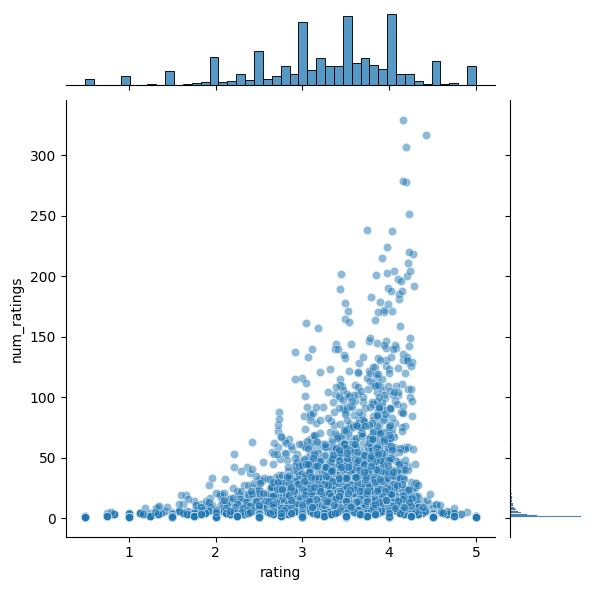

In [16]:
# create a joint plot to visualize the relationship between average rating and number of ratings
sns.jointplot(data = ratings, x = 'rating', y = 'num_ratings', kind = 'scatter', alpha = 0.5)
plt.show()

For movies with higher ratings tend to have more ratings, for highly rated movies above 4.0 generally have higher number of ratings. This is a clear indication of some positive correlation.

The marginal histograms shows the distribution of ratings and number of ratings. It clear that most movies have fewer ratings indicating skewed distribution. Majority of the movies have ratings between 3 and 4.5 with very few low rated movies.

There are few movies which have extremely high number of ratings above 200, while some movies have low ratings indicating some outliers.


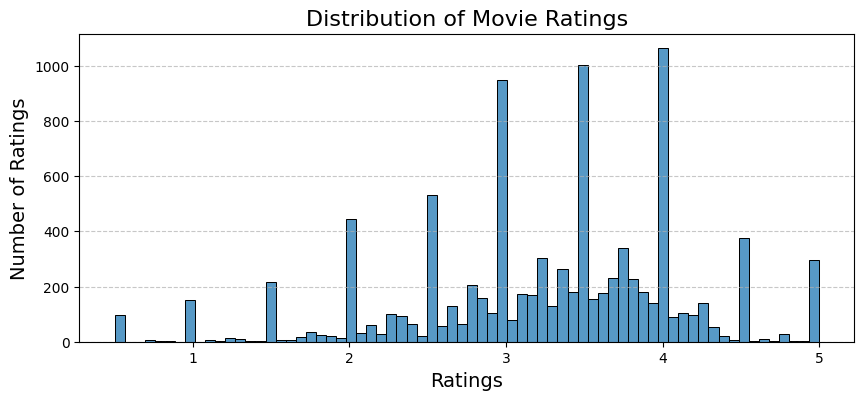

In [17]:
# Here lets visualize the distribution of movies
plt.figure(figsize=(10,4))

sns.histplot(ratings['rating'], bins=70, kde=False) # create a histogram

plt.xlabel("Ratings", fontsize=14)  
plt.ylabel("Number of Ratings", fontsize=14) 
plt.title("Distribution of Movie Ratings", fontsize=16)  

# Show grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


For most movies they are rated within the range 3-4 which means that most users tend to be biased on movies with high ratings compared to the ones with low ratings.

The are some few movies which have extremely high number of ratings above 200 conversely with some having low ratings indicating some sort of outliers


## **5. Preparing the Data for Surprise**

In [18]:
# Define the rating scale (e.g., 0.5 to 5.0)
reader = Reader(rating_scale=(0.5, 5.0))

# Convert the DataFrame to a Surprise dataset
data = Dataset.load_from_df(movie_analysis_df[["userId", "movieId", "rating"]], reader)
data

In [19]:
dataset = data.build_full_trainset() # converts raw rating data into trainset having all the available ratings

print('Number of Users: ', dataset.n_users, '\n') # Gets the number of unique users (userId) in the dataset.

print('Number of items: ', dataset.n_items) # Gets the number of unique items (movieId) being rated.


Number of Users:  610 

Number of items:  9724


By considering the neighborhood-based methods lets use the majority.. the higher number of users or items
hence use the item Based Recommender system.

In [20]:
# Split the dataset
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

## **6. Building the Item-Based Collaborative Filtering Model**
Lets build the recommendation system using **item-based collaborative filtering**, with this approach we recommend items (movies) based on the similarities between them.

# Build the recommender system using the KNNBasic algorithms

In [21]:
knn_basic = KNNBasic(sim_options = {'name': 'pearson', 'user_based': False})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs = 1)

# for user_based: True indicates that the similarity would be computed between users

# for user_based: False indicates that the similarity would be computed between items

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [22]:
# here we print out the average RMSE for the test set
for i in cv_knn_basic.items():
    print(i)
    
    
print("-----")
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.95753601, 0.97705455, 0.96800672, 0.96611356, 0.97561396]))
('test_mae', array([0.74298395, 0.75821121, 0.75310359, 0.74905094, 0.75719452]))
('fit_time', (29.324373483657837, 52.2799232006073, 36.8712682723999, 32.976744174957275, 29.132128953933716))
('test_time', (11.660786867141724, 18.397166967391968, 10.880019426345825, 10.05967926979065, 9.44266414642334))
-----
0.9688649603505219


('test_rmse', array([0.96184034, 0.97737356, 0.96979811, 0.97231736, 0.97006331]))

these are the RMSE values obtained from each fold of the cross-validation. Lower values indicate better performance.

0.9702785351666356 this is the aggregated score the mean rmse across all the folds which provides a single value summarizing the performance of 
the model

In [23]:
# lets evaluate the metric performance for the KNNBasic algorithm 
mean_rmse_basic = np.mean(cv_knn_basic['test_rmse'])
mean_rmse_basic

0.9688649603505219

# Build item based model using KNNBaseline 

In [24]:
# cross validating with KNNBaseline
knn_base = KNNBaseline(sim_options = {'name':'pearson', 'user_based': False})

cv_knn_base = cross_validate(knn_base, data, n_jobs = 1)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [25]:
# print out the average score for the test set
mean_rmse_base = np.mean(cv_knn_base['test_rmse'])
mean_rmse_base

0.8794227792829716

In [26]:
# Compare the two algorithms then determine which has better performance
if mean_rmse_base < mean_rmse_basic:
    print("cv_knn_base has better performance.")
else:
    print("cv_knn_basic has better performance.")

cv_knn_base has better performance.


In [27]:
movie_analysis_df.groupby('title')['rating'].count().sort_values(ascending = False).head(10)

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: rating, dtype: int64

In [28]:
# create a function that picks out the movieId given the movie title, its from the function we are able to assert whether that title is present on the 
# movie_analysis_df. 
def find_movie_id_by_title(movie_analysis_df, title):
    # Check if the title exists in the DataFrame
    if title in movie_analysis_df['title'].values:
        # Extract the movie ID
        movie_id = movie_analysis_df[movie_analysis_df['title'] == title]['movieId'].values[0]
        return movie_id
    else:
        return None

# Example usage
title = "Matrix, The (1999)"  # Replace with the actual movie title you are searching for
movie_id = find_movie_id_by_title(movie_analysis_df, title)
print(f"The movie ID for the title '{title}' is {movie_id}")

The movie ID for the title 'Matrix, The (1999)' is 2571


In [29]:
# lets set a movie title to check whether the function works
title = "Shooter"  # Replace with the actual movie title you are searching for
movie_id = find_movie_id_by_title(movie_analysis_df, title)
print(f"The movie ID for the title '{title}' is {movie_id}")

The movie ID for the title 'Shooter' is None


# Create a Collaborative filtering using SVD.

SVD algorithms finds the movies that the users who liked a given movie also liked

In [30]:
data

# train the SVD model
svd_model = SVD().fit(train_set)
svd_model

 Collaborative Filtering (Using Surprise SVD)
This method finds movies that users who liked a given movie also liked.

Step 1: Train a Collaborative Filtering Model

In [31]:
def get_top_5_recommendations(movie_analysis_df, svd_model, title):
    movie_id = find_movie_id_by_title(movie_analysis_df, title) # gets the movie id for a given title
    
    if movie_id is None:
        return f"Movie '{title}' not found in the dataset."
    
    movie_IDS = movie_analysis_df['movieId'].unique()
    
    # here we predict the ratings for all the movies with exceptions for the selected movie
    predictions = [(mv_id, svd_model.predict(uid = 1, iid = mv_id).est) for mv_id in movie_IDS if mv_id != movie_id]
    
    
    top_5_movies = sorted(predictions, key = lambda x: x[1], reverse = True)[:5] # sort by the predicted rating and get the top 5 movies
    
    # get the movie title for the recommended movie_IDS
    recommended_movies = movie_analysis_df[movie_analysis_df['movieId'].isin([x[0] for x in top_5_movies])][['movieId', 'title']].drop_duplicates()
    
    return recommended_movies
    

In [ ]:
# lets apply the function to get the top 5 recommended movie by title for the  "Matrix, The (1999)"
title = "Matrix, The (1999)"
recommendations = get_top_5_recommendations(movie_analysis_df, svd_model, title)
print(recommendations)

      movieId                                              title
1568      260          Star Wars: Episode IV - A New Hope (1977)
3570      527                            Schindler's List (1993)
5548      919                           Wizard of Oz, The (1939)
6641     1136             Monty Python and the Holy Grail (1975)
6777     1196  Star Wars: Episode V - The Empire Strikes Back...


In [40]:
# get the top 5 recommendations for the "Salem's Lot (2004)" movie title
title_1 = "Salem's Lot (2004)" 
recommendations_salem = get_top_5_recommendations(movie_analysis_df, svd_model, title_1)
print(recommendations_salem)

Movie 'Salem's Lot (2004)' not found in the dataset.


In [39]:
title_2 = "Pulp Fiction (1994)"
recommendations_1 = get_top_5_recommendations(movie_analysis_df, svd_model, title_2)
print(recommendations_1)

      movieId                                              title
1568      260          Star Wars: Episode IV - A New Hope (1977)
3570      527                            Schindler's List (1993)
5548      919                           Wizard of Oz, The (1939)
6641     1136             Monty Python and the Holy Grail (1975)
6777     1196  Star Wars: Episode V - The Empire Strikes Back...


In [42]:
title_3 = "Sex, Drugs & Taxation (2013)"
recommendations_2 = get_top_5_recommendations(movie_analysis_df, svd_model, title_3)
print(recommendations_2)

      movieId                                              title
1568      260          Star Wars: Episode IV - A New Hope (1977)
3570      527                            Schindler's List (1993)
5548      919                           Wizard of Oz, The (1939)
6641     1136             Monty Python and the Holy Grail (1975)
6777     1196  Star Wars: Episode V - The Empire Strikes Back...


## Conclusions 
Since most movies cluster in the 3-4 range, achieving a rating above 4.0 is a strong indicator of success.
Studios could benchmark their movies against top-rated ones to identify what drives higher ratings (e.g., strong storytelling, production quality).
Marketing campaigns could focus on movies with higher ratings (4.0+), as they are more likely to attract new viewers.

Studios should focus on maintaining a rating above 3 to be considered acceptable by audiences.